# Baysian  DiD

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_names  years  island_ids region_codes region_names  \
0           鹿久居島   1975          68        33342          日生町   
1           鹿久居島   1980          68        33342          日生町   
2           鹿久居島   1985          68        33342          日生町   
3           鹿久居島   1990          68        33342          日生町   
4           鹿久居島   1995          68        33342          日生町   
..           ...    ...         ...          ...          ...   
583           戸島   2000         218        38203         宇和島市   
584           戸島   2005         218        38203         宇和島市   
585           戸島   2010         218        38203         宇和島市   
586           戸島   2015         218        38203         宇和島市   
587           戸島   2020         218        38203         宇和島市   

     prefecture_codes  populations  treatment_group  treatment_group_mainland  \
0                  33           46                1                         1   
1                  33           52                1                         1   
2                  33           53                1                         1   
3                  33           54                1                         1   
4                  33           45                1                         1   
..                ...          ...              ...                       ...   
583                38          451                0                         0   
584                38          473                0                         0   
585                38          414                0                         0   
586                38          344                0                         0   
587                38          263                0                         0   

     year_bridges_opened  ...  cohort_2000  years_cohort_2000  cohort_2004  \
0                   2015  ...            0                  0            0   
1                   2015  ...            0                  0            0   
2                   2015  ...            0                  0            0   
3                   2015  ...            0                  0            0   
4                   2015  ...            0                  0            0   
..                   ...  ...          ...                ...          ...   
583                    0  ...            0                  0            0   
584                    0  ...            0                  0            0   
585                    0  ...            0                  0            0   
586                    0  ...            0                  0            0   
587                    0  ...            0                  0            0   

     years_cohort_2004 cohort_2011  years_cohort_2011  cohort_2015  \
0                    0           0                  0            1   
1                    0           0                  0            1   
2                    0           0                  0            1   
3                    0           0                  0            1   
4                    0           0                  0            1   
..                 ...         ...                ...          ...   
583                  0           0                  0            0   
584                  0           0                  0            0   
585                  0           0                  0            0   
586                  0           0                  0            0   
587                  0           0                  0            0   

     years_cohort_2015  cohort_2016  years_cohort_2016  
0                  -40            0                  0  
1                  -35            0                  0  
2                  -30            0                  0  
3                  -25            0                  0  
4                  -20            0                  0  
..                 ...          ...                ...  
583                  0            0                  0  
584             

## TWFE

$$
\mu_{it} = \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_g \mathbf{1} \{t-E_i \in g\} + \epsilon_{it}
$$

- $\text{island}_i$:
  - 個体効果
- $\text{year}_t$:
  - 年効果
- $E_i$:
  - 処置開始年

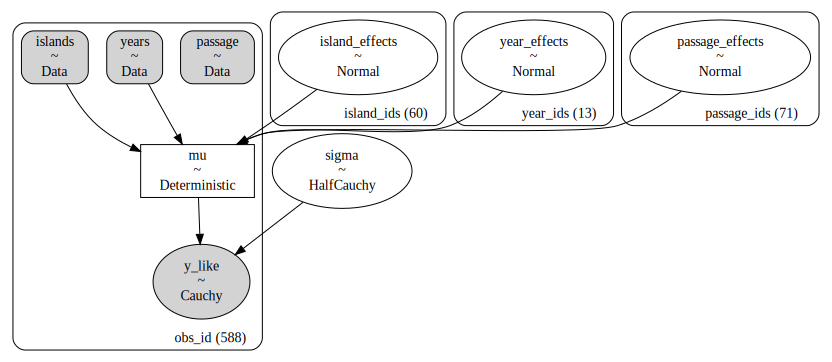

In [3]:
# 経過期間ダミーを作成
passages = dmatrix('C(passage_of_year)', data=df, return_type='dataframe')

# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passage = pm.Data('passage', df['passage_of_year'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')
    passage_effects = pm.Normal('passage_effects', mu=0, sigma=100, dims='passage_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000)

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + pm.math.dot(passages, passage_effects), dims='obs_id')

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(twfe)

In [ ]:
with twfe:
    idata_twfe = pm.sample(draws=3000, tune=2000, nuts_sampler='numpyro', random_seed=42)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.to_netcdf(idata_twfe, './sample/sample_baysian_did_twfe.nc')

'./sample/sample_baysian_did_twfe.nc'

In [7]:
az.summary(idata_twfe)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
island_effects[68]   2.529  14.954 -24.832   31.835      0.490    0.347   
island_effects[69]   1.393  14.354 -24.974   28.804      0.488    0.345   
island_effects[70]  -0.527  26.143 -50.714   47.739      0.607    0.429   
island_effects[71]   9.557  16.182 -20.712   40.074      0.517    0.366   
island_effects[76]  -5.685  14.341 -31.555   22.065      0.488    0.345   
...                    ...     ...     ...      ...        ...      ...   
mu[583]            -12.766   1.978 -16.581   -9.070      0.018    0.013   
mu[584]             -5.136   2.442  -9.585   -0.511      0.023    0.016   
mu[585]            -13.396   1.937 -17.129   -9.806      0.018    0.013   
mu[586]            -13.299   2.083 -17.299   -9.584      0.019    0.014   
mu[587]            -18.616   2.248 -22.745  -14.348      0.021    0.015   

                    ess_bulk  ess_tail  r_hat  
island_effects[68]     931.0    2062.0    1.0  
island_effects[69]     863.0    1898.0    1.0  
island_effects[70]    1855.0    3474.0    1.0  
island_effects[71]     978.0    2177.0    1.0  
island_effects[76]     863.0    1960.0    1.0  
...                      ...       ...    ...  
mu[583]              11913.0    9473.0    1.0  
mu[584]              10968.0    9660.0    1.0  
mu[585]              11564.0   10101.0    1.0  
mu[586]              11563.0   10165.0    1.0  
mu[587]              11030.0   10071.0    1.0  

[733 rows x 9 columns]

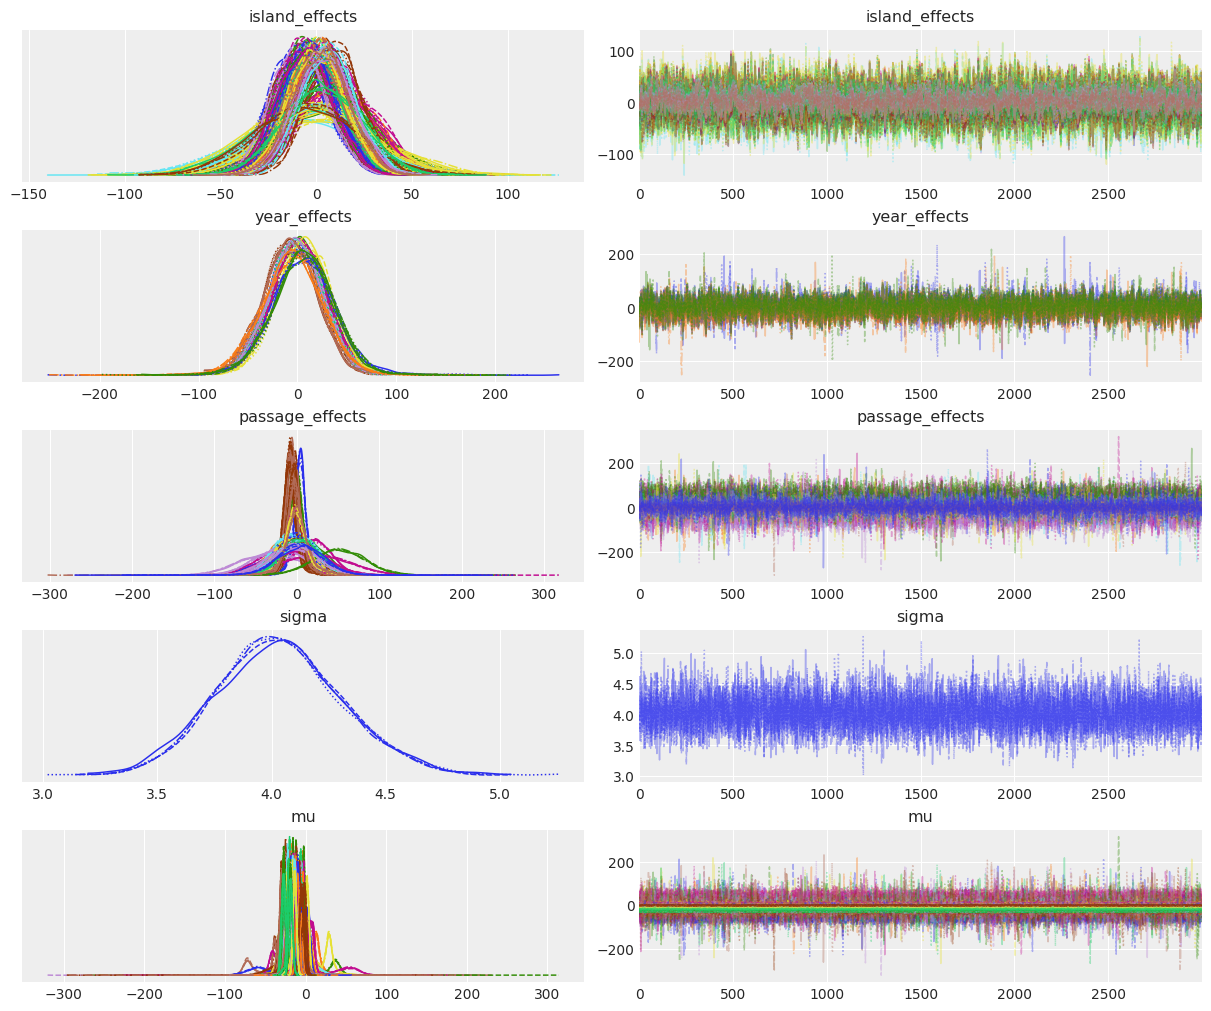

In [8]:
az.plot_trace(idata_twfe);

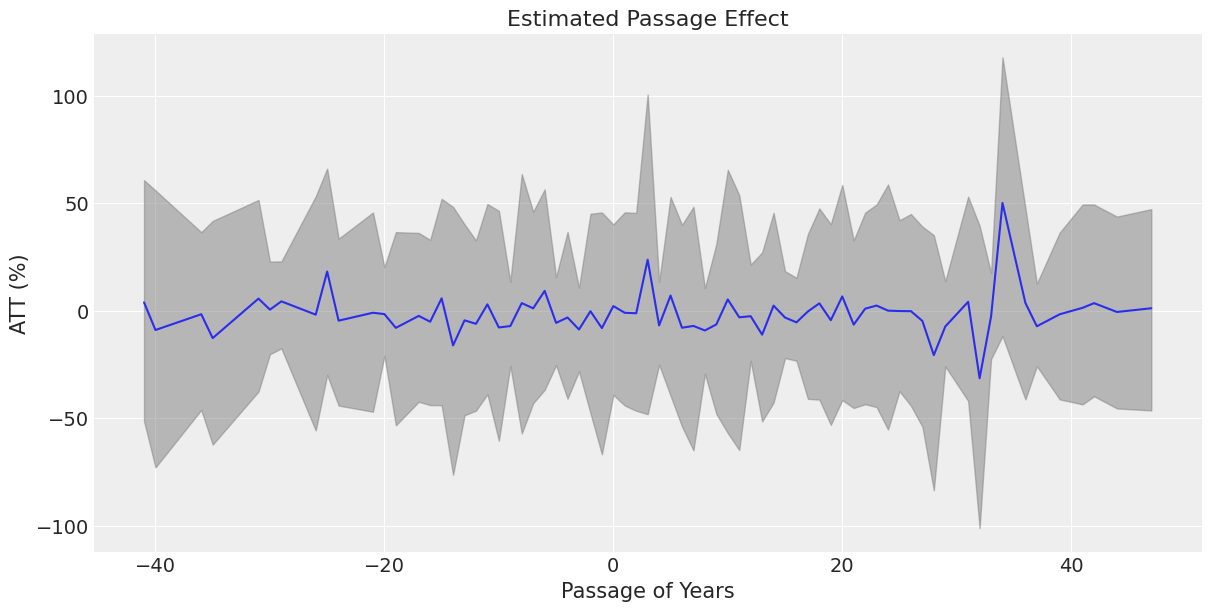

In [9]:
summary = az.summary(idata_twfe, var_names=['passage_effects'], hdi_prob=.95)
df_passage_effects = summary.reset_index()
# 数値部分を取り出す関数
def extract_number(index_str):
    match = re.search(r'\[(.*?)\]', index_str)
    return int(match.group(1)) if match else None

# 数値部分を新しい列として追加
df_passage_effects['passage_years'] = df_passage_effects['index'].apply(extract_number)
df_passage_effects.sort_values('passage_years', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='passage_years', y='mean', data=df_passage_effects)
plt.fill_between(
    df_passage_effects['passage_years'],
    df_passage_effects['hdi_2.5%'],
    df_passage_effects['hdi_97.5%'],
    color='gray', alpha=0.5, label='95% HDI'
)
plt.title('Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

## Staggered DiD

$$
\mu_{it} = \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_{gl} \mathbf{1} \{\text{year}-\text{intervention}_i \in g\} \cdot \mathbf{1} \{\text{intervention}_i \in e\} + \epsilon_{it}
$$

- $\text{island}_i$:
  - 島効果
- $\text{year}_t$:
  - 年効果
- $E_i$:
  - 処置開始年
- $\mathbf{1} \{t-E_i \in g\}$:
  - 経過年数ダミー
- $\mathbf{1} \{E_i \in e\}$
  - 処置開始年ダミー


### モデル1

In [3]:
cohort_list = df['year_bridges_opened'].unique()
cohort_list.sort()
for cohort in cohort_list:
    globals()[f'c{cohort}'] = dmatrix(f'C(years_cohort_{cohort})-1', data=df, return_type='dataframe')
    print(cohort)

0
1973
1976
1979
1983
1987
1988
1989
1991
1992
1995
1996
1999
2000
2004
2011
2015
2016


In [4]:
# cohort effectのmuを定義
def get_mu_cohort(cohort_list):
    return {f'mu_c{cohort}': pm.Normal(f'mu_c{cohort}', mu=0, sigma=100, dims=f'n_c{cohort}') for cohort in cohort_list}

# cohort effectの式を取得
def get_cohort_effects(cohort_list):
    return sum(pm.math.dot(globals()[f'c{cohort}'], globals()[f'mu_c{cohort}']) for cohort in cohort_list)

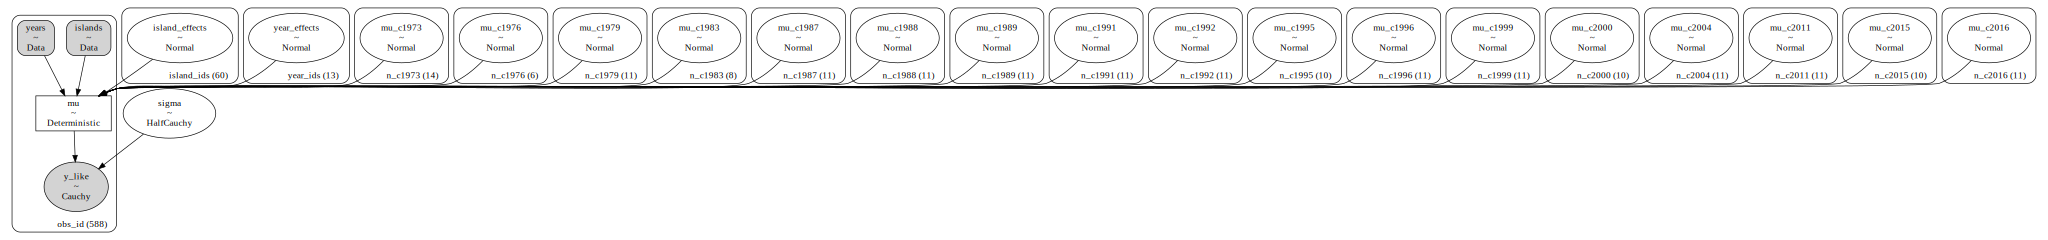

In [4]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'n_c1973': c1973,
    'n_c1976': c1976,
    'n_c1979': c1979,
    'n_c1983': c1983,
    'n_c1987': c1987,
    'n_c1988': c1988,
    'n_c1989': c1989,
    'n_c1991': c1991,
    'n_c1992': c1992,
    'n_c1995': c1995,
    'n_c1996': c1996,
    'n_c1999': c1999,
    'n_c2000': c2000,
    'n_c2004': c2004,
    'n_c2011': c2011,
    'n_c2015': c2015,
    'n_c2016': c2016,
    'obs_id': df.index
}

with pm.Model(coords=coords) as staggered:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000)

    # cohort * passage
    mu_c1973 = pm.Normal('mu_c1973', mu=0, sigma=100, dims='n_c1973')
    mu_c1976 = pm.Normal('mu_c1976', mu=0, sigma=100, dims='n_c1976')
    mu_c1979 = pm.Normal('mu_c1979', mu=0, sigma=100, dims='n_c1979')
    mu_c1983 = pm.Normal('mu_c1983', mu=0, sigma=100, dims='n_c1983')
    mu_c1987 = pm.Normal('mu_c1987', mu=0, sigma=100, dims='n_c1987')
    mu_c1988 = pm.Normal('mu_c1988', mu=0, sigma=100, dims='n_c1988')
    mu_c1989 = pm.Normal('mu_c1989', mu=0, sigma=100, dims='n_c1989')
    mu_c1991 = pm.Normal('mu_c1991', mu=0, sigma=100, dims='n_c1991')
    mu_c1992 = pm.Normal('mu_c1992', mu=0, sigma=100, dims='n_c1992')
    mu_c1995 = pm.Normal('mu_c1995', mu=0, sigma=100, dims='n_c1995')
    mu_c1996 = pm.Normal('mu_c1996', mu=0, sigma=100, dims='n_c1996')
    mu_c1999 = pm.Normal('mu_c1999', mu=0, sigma=100, dims='n_c1999')
    mu_c2000 = pm.Normal('mu_c2000', mu=0, sigma=100, dims='n_c2000')
    mu_c2004 = pm.Normal('mu_c2004', mu=0, sigma=100, dims='n_c2004')
    mu_c2011 = pm.Normal('mu_c2011', mu=0, sigma=100, dims='n_c2011')
    mu_c2015 = pm.Normal('mu_c2015', mu=0, sigma=100, dims='n_c2015')
    mu_c2016 = pm.Normal('mu_c2016', mu=0, sigma=100, dims='n_c2016')

    cohort_effects = pm.math.dot(c1973, mu_c1973) + pm.math.dot(c1976, mu_c1976) + pm.math.dot(c1979, mu_c1979) + pm.math.dot(c1983, mu_c1983) + pm.math.dot(c1987, mu_c1987) + pm.math.dot(c1988, mu_c1988) + pm.math.dot(c1989, mu_c1989) + pm.math.dot(c1991, mu_c1991) + pm.math.dot(c1992, mu_c1992) + pm.math.dot(c1995, mu_c1995) + pm.math.dot(c1996, mu_c1996) + pm.math.dot(c1999, mu_c1999) + pm.math.dot(c2000, mu_c2000) + pm.math.dot(c2004, mu_c2004) + pm.math.dot(c2011, mu_c2011) + pm.math.dot(c2015, mu_c2015) + pm.math.dot(c2016, mu_c2016)

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + cohort_effects, dims='obs_id')

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(staggered)

In [ ]:
with staggered:
    idata_staggered = pm.sample(
        draws=4000, # R-hat>1.01 : 4000, 2000
        tune=3000,
        nuts_sampler="numpyro",
        random_seed=42
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.to_netcdf(idata_staggered, './sample/sample_baysian_did_staggered.nc')

'./sample/sample_baysian_did_staggered.nc'

In [8]:
az.summary(idata_staggered, hdi_prob=0.95, var_names=['year_effects'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
year_effects[1975]  -0.791  27.754   -49.089     58.058      3.830    2.724   
year_effects[1980]   3.083  27.708   -49.223     57.738      3.823    2.718   
year_effects[1985]   5.181  27.720   -46.437     60.372      3.823    2.718   
year_effects[1990]   5.279  27.724   -44.026     62.677      3.819    2.715   
year_effects[1995]  -5.341  27.708   -54.777     51.956      3.822    2.718   
year_effects[2000]   1.501  27.718   -47.481     59.282      3.823    2.718   
year_effects[2005]  13.142  27.736   -36.632     69.906      3.821    2.717   
year_effects[2010]   0.100  27.701   -49.174     57.677      3.824    2.719   
year_effects[2015]   0.807  27.731   -49.631     57.254      3.828    2.722   
year_effects[2020]  -5.994  27.722   -55.906     50.690      3.822    2.718   
year_effects[1960]   0.840  71.184  -139.445    135.358      2.883    2.040   
year_effects[1965]   1.677  77.063  -151.512    150.579      3.831    2.711   
year_effects[1970]   0.487  74.746  -149.871    146.814      3.600    2.547   

                    ess_bulk  ess_tail  r_hat  
year_effects[1975]      53.0     142.0   1.08  
year_effects[1980]      53.0     148.0   1.08  
year_effects[1985]      53.0     149.0   1.08  
year_effects[1990]      54.0     152.0   1.08  
year_effects[1995]      53.0     149.0   1.08  
year_effects[2000]      53.0     150.0   1.08  
year_effects[2005]      53.0     147.0   1.08  
year_effects[2010]      53.0     158.0   1.08  
year_effects[2015]      53.0     150.0   1.08  
year_effects[2020]      53.0     148.0   1.08  
year_effects[1960]     608.0    1283.0   1.01  
year_effects[1965]     405.0     942.0   1.00  
year_effects[1970]     433.0     695.0   1.01

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


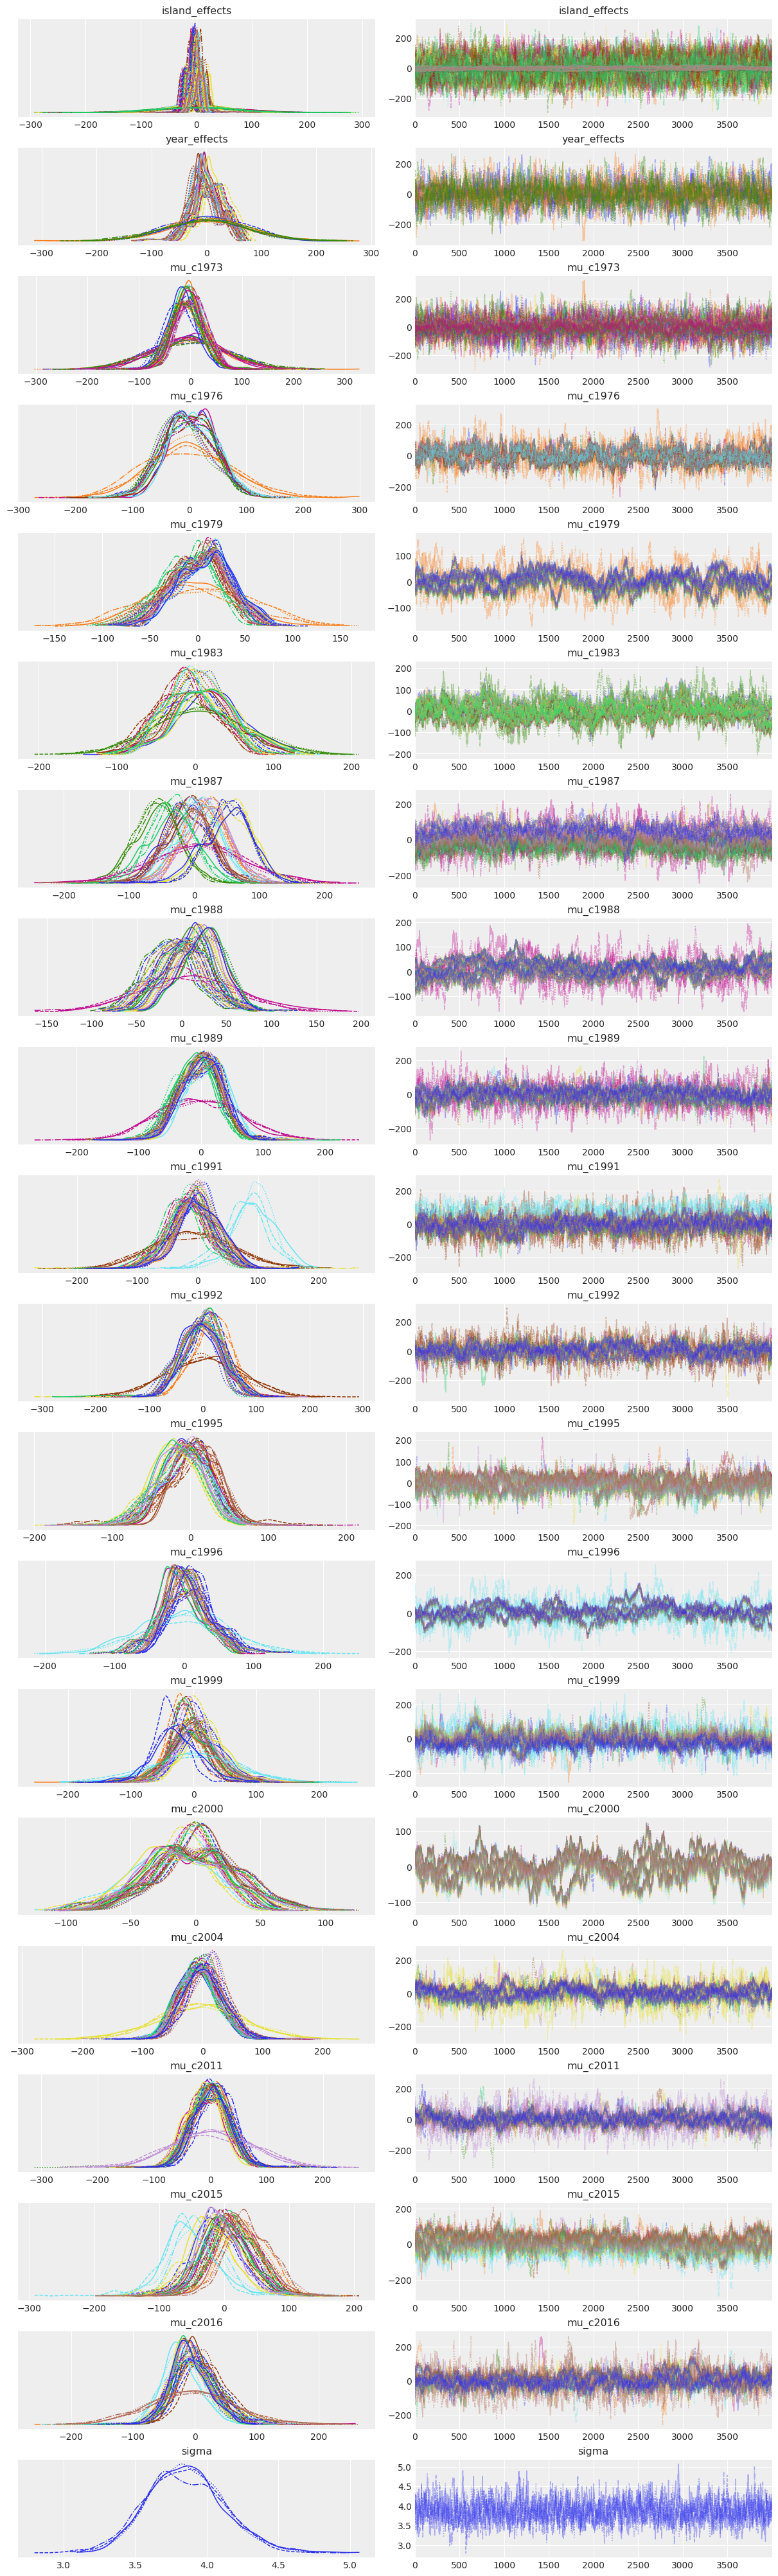

In [9]:
az.plot_trace(idata_staggered);

In [27]:
def get_passage_effects(cohort):
    summary = az.summary(idata_staggered, var_names=[f'mu_c{cohort}'], hdi_prob=.95)
    df_cohort_effects = summary.reset_index()
    # 数値部分を取り出す関数
    def extract_number(index_str):
        match = re.search(r'\[(-?\d+)\]', index_str)
        return int(match.group(1)) if match else None

    # 数値部分を新しい列として追加
    df_cohort_effects['passage_years'] = df_cohort_effects['index'].apply(extract_number)
    df_cohort_effects.sort_values('passage_years', inplace=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='passage_years', y='mean', data=df_cohort_effects, label='mean')
    plt.fill_between(
        df_cohort_effects['passage_years'],
        df_cohort_effects['hdi_2.5%'],
        df_cohort_effects['hdi_97.5%'],
        color='gray', alpha=0.5, label='95% HDI'
    )
    plt.ylim(-100, 100)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Estimated Passage Effect of {cohort}')
    plt.xlabel('Passage of Years')
    plt.ylabel('ATT (%)')
    plt.show()

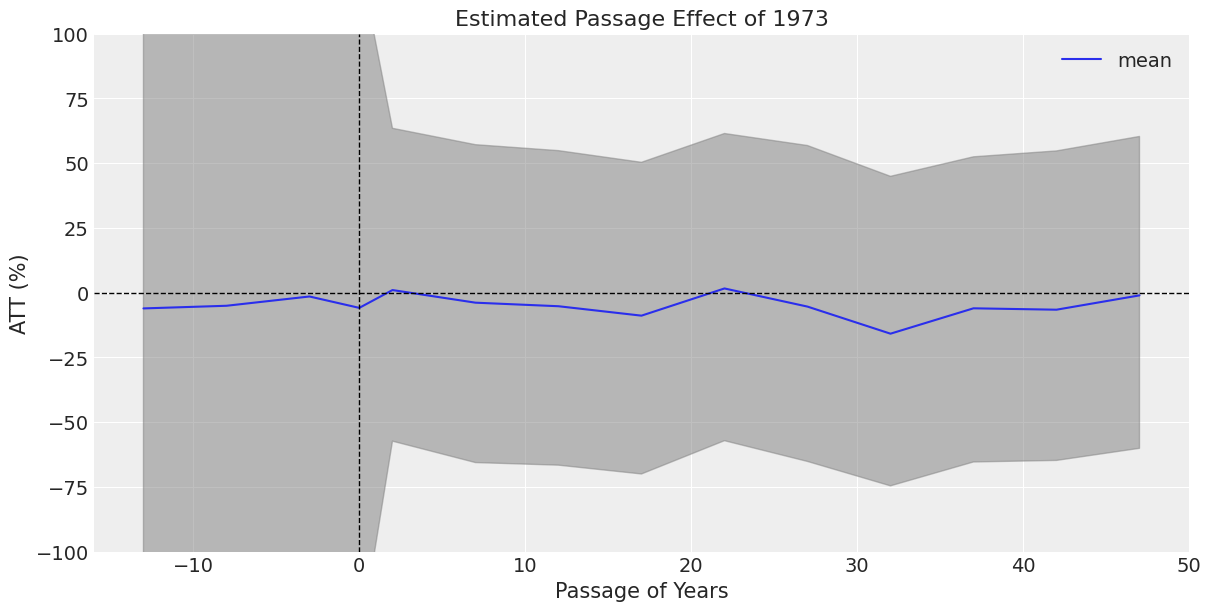

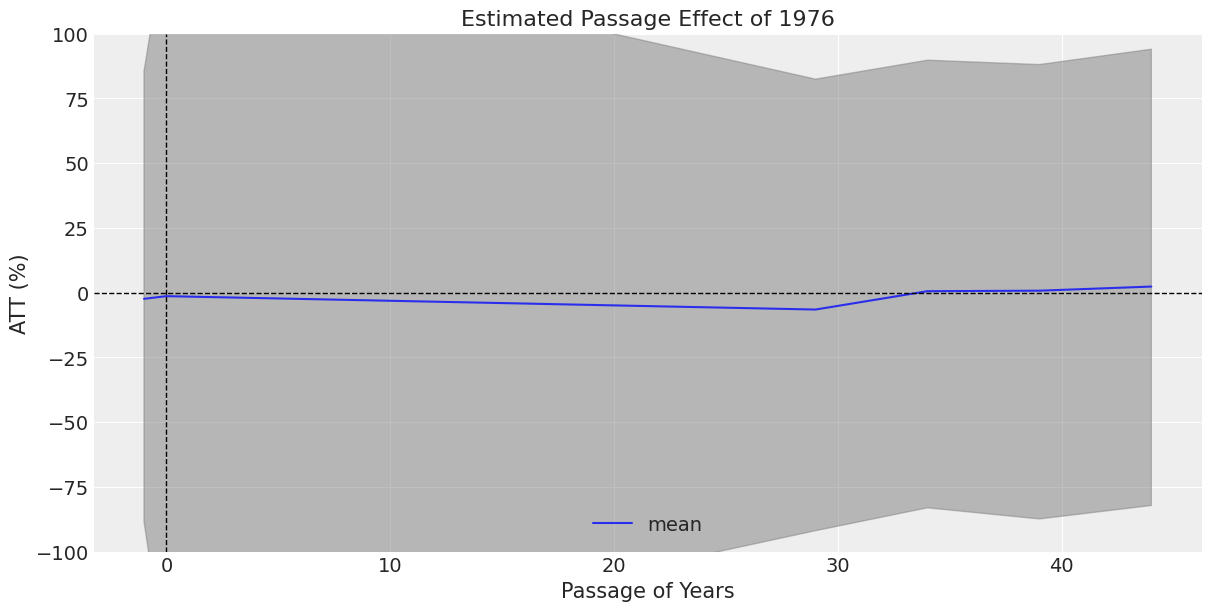

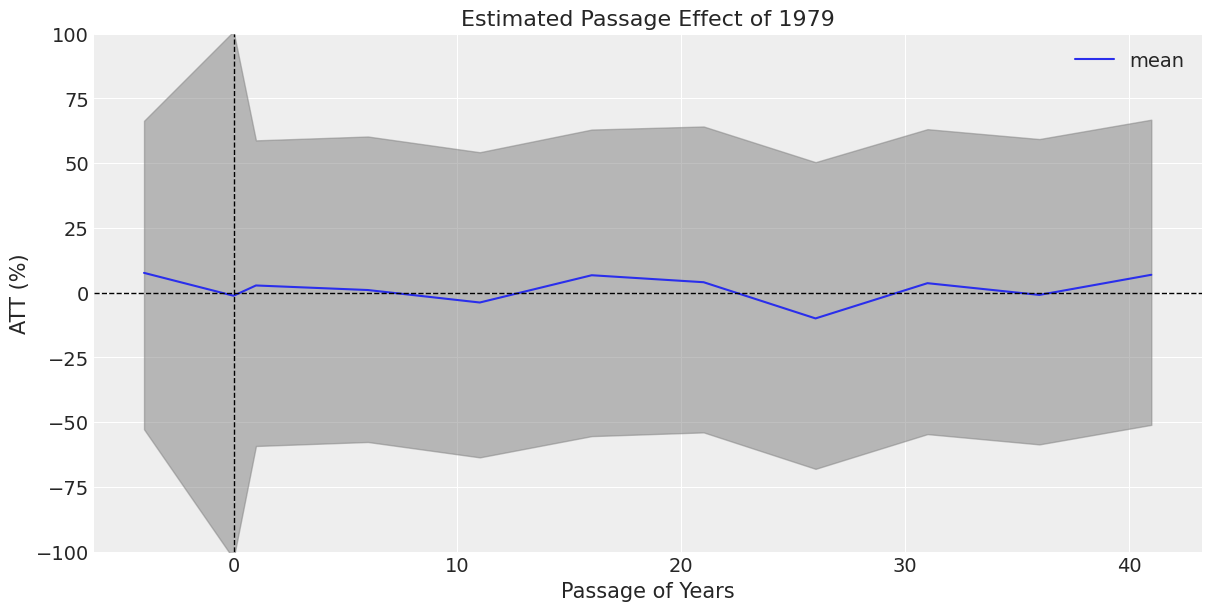

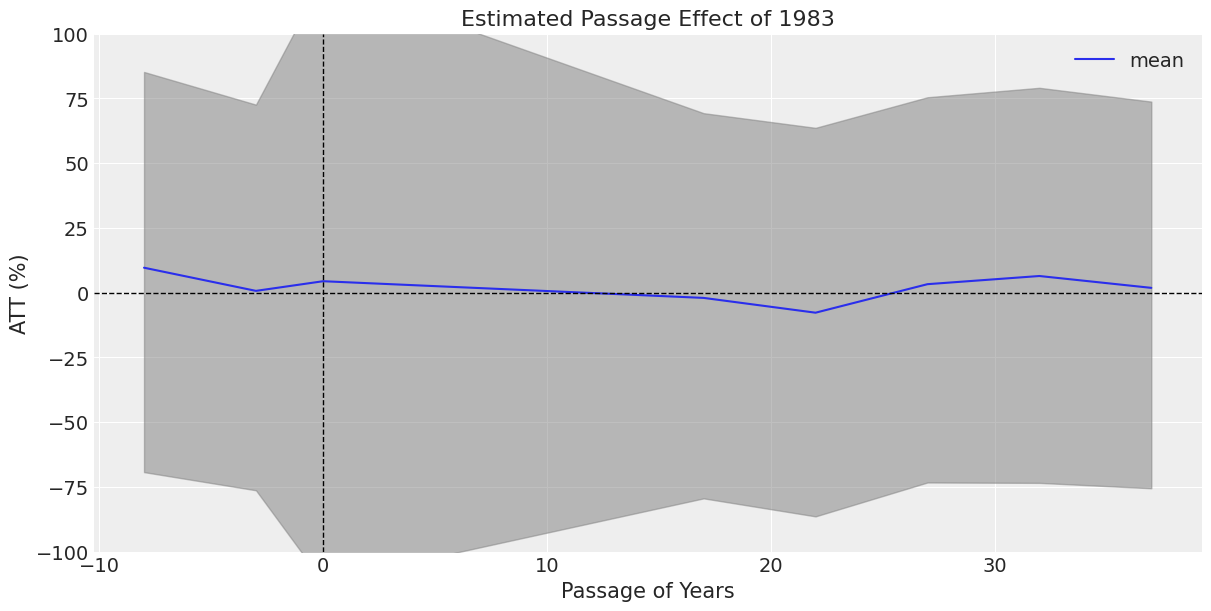

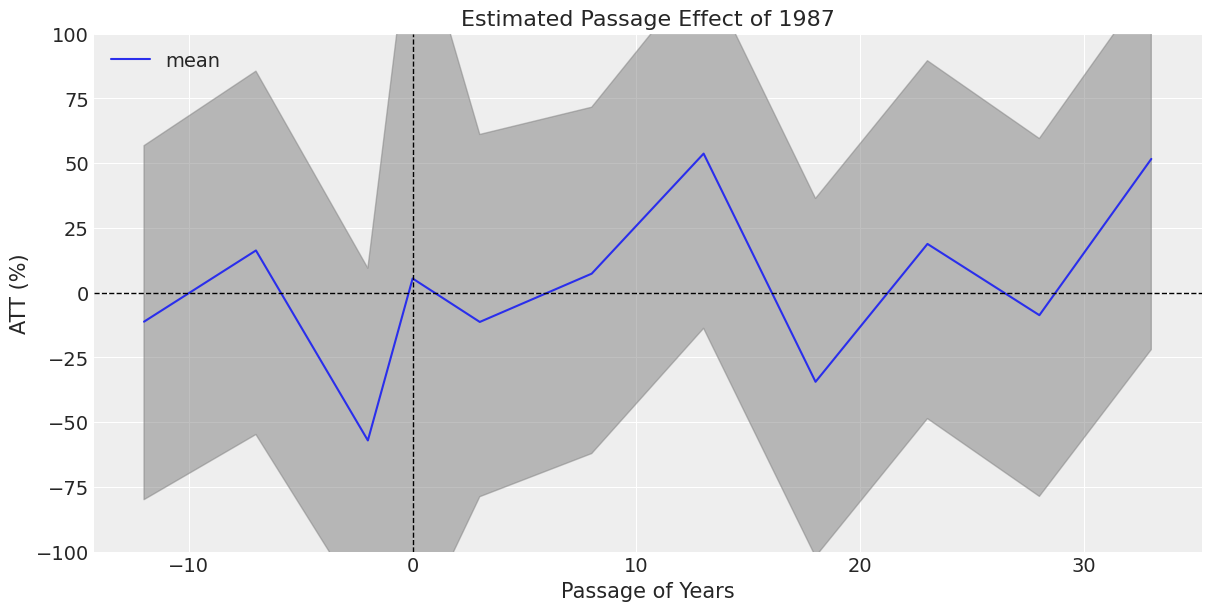

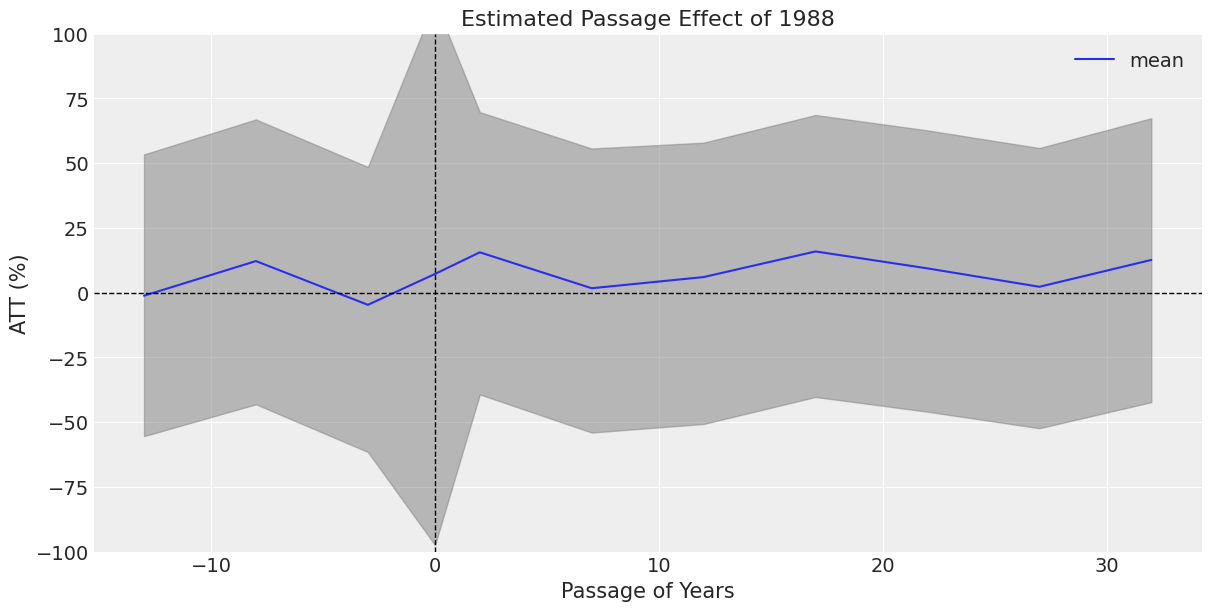

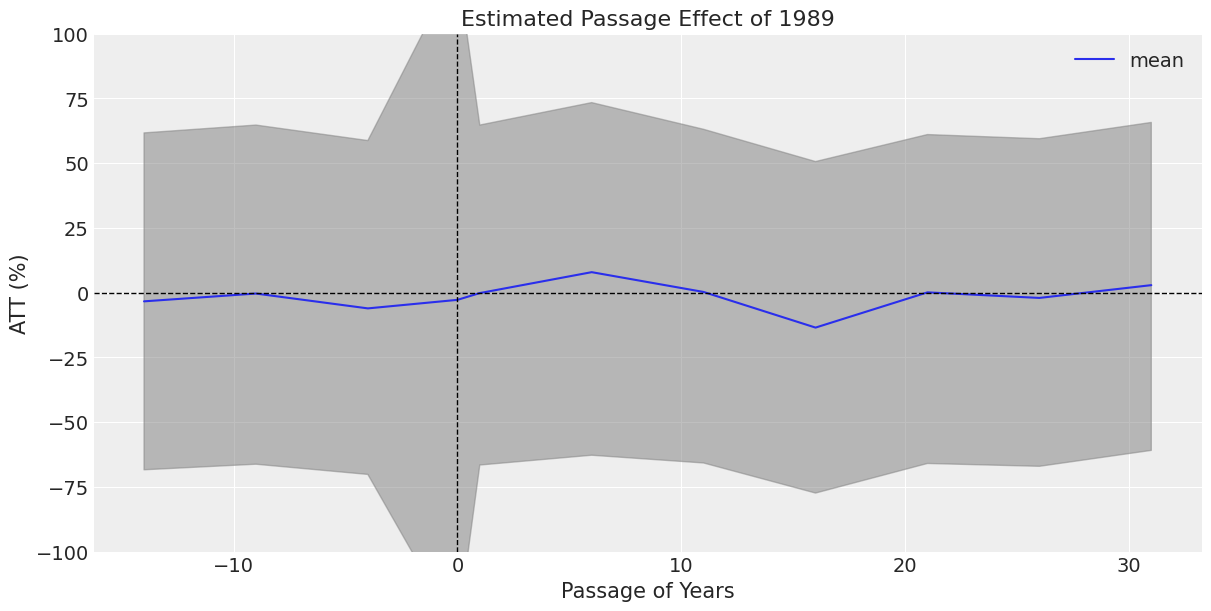

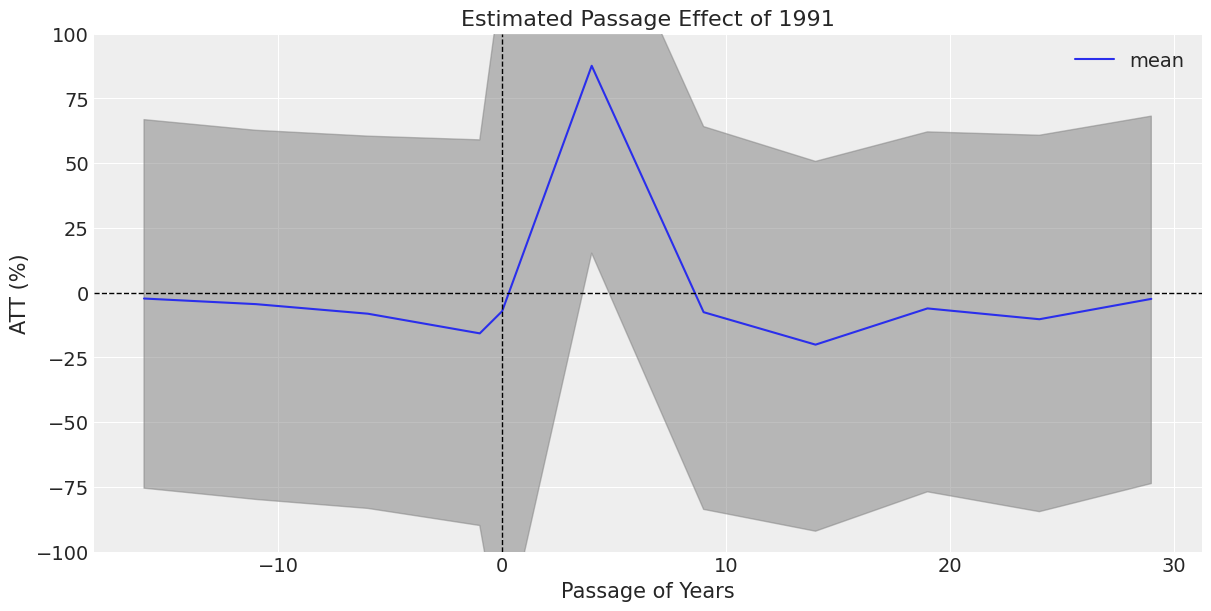

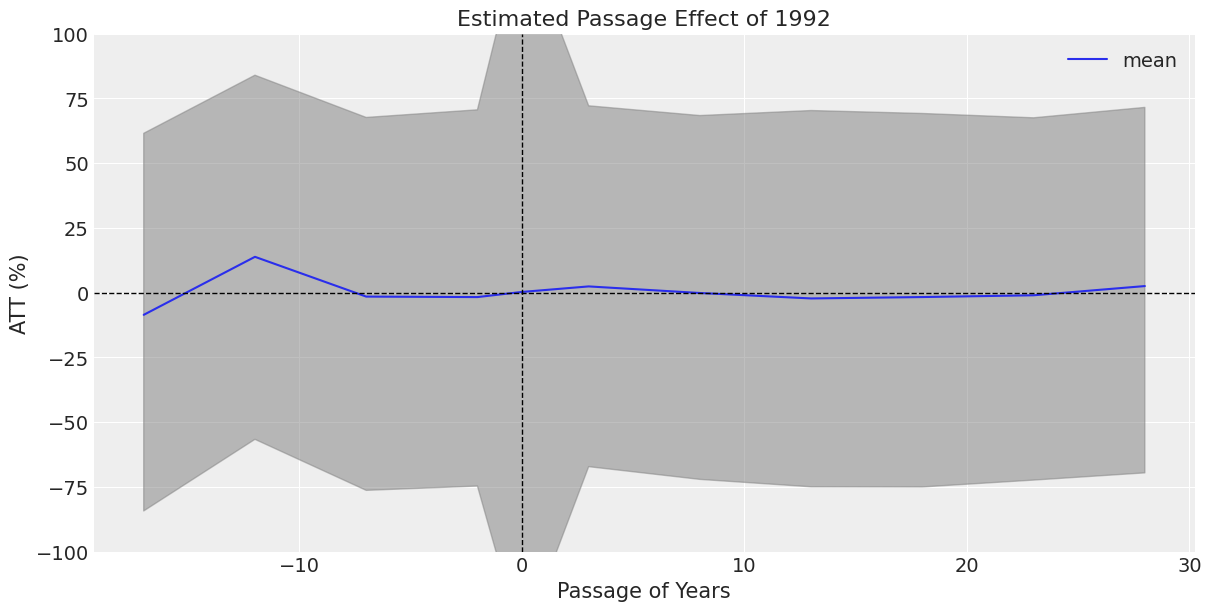

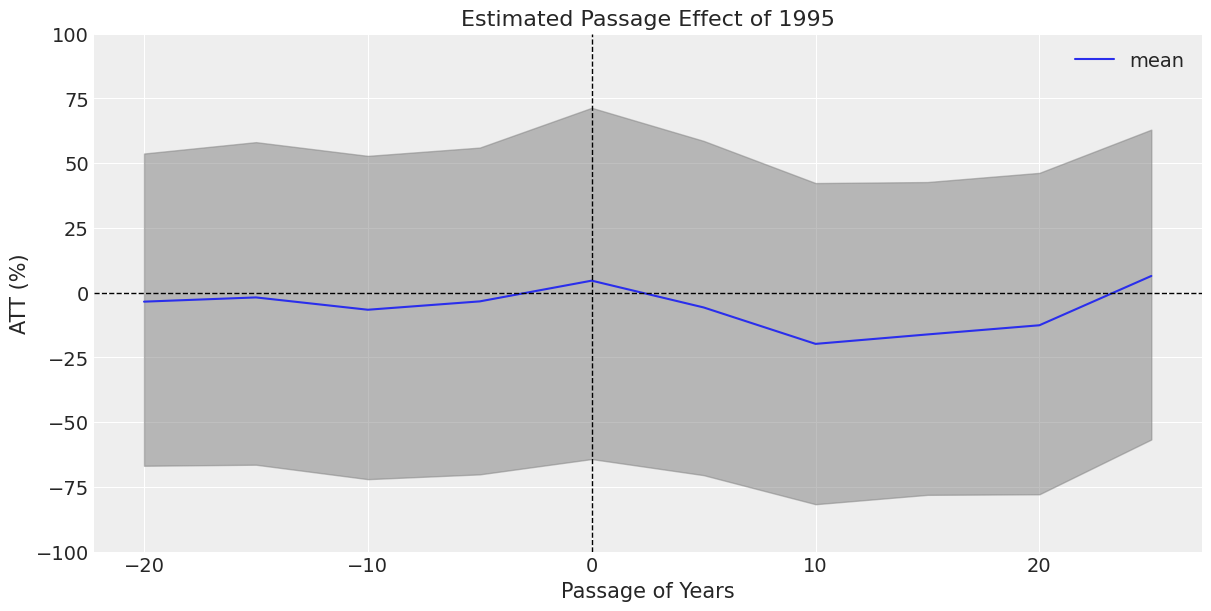

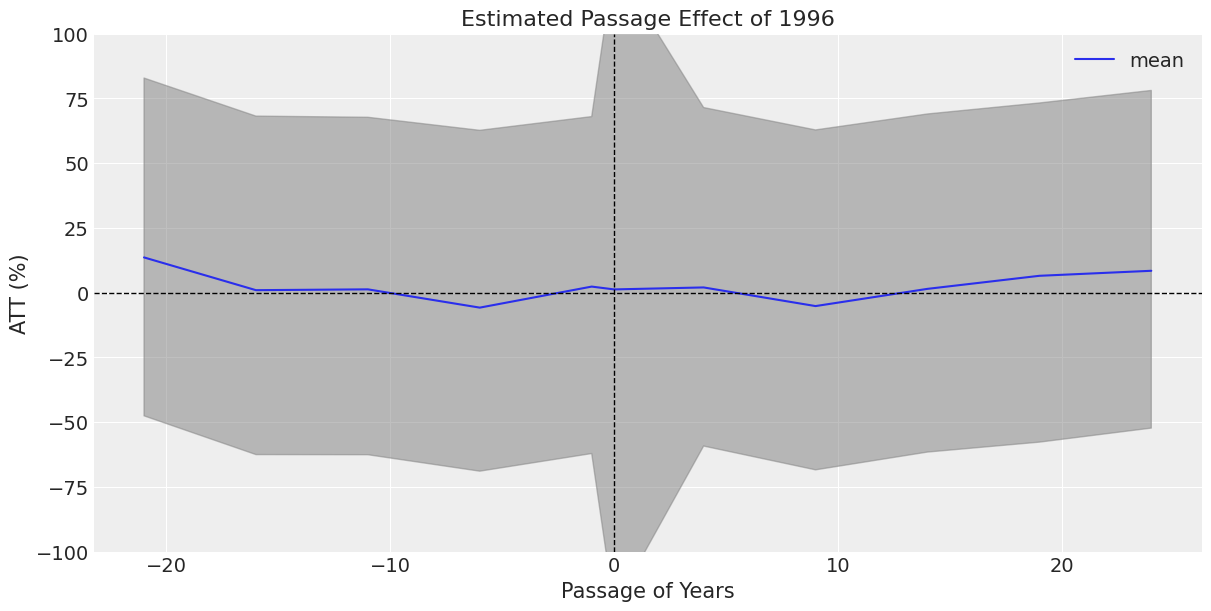

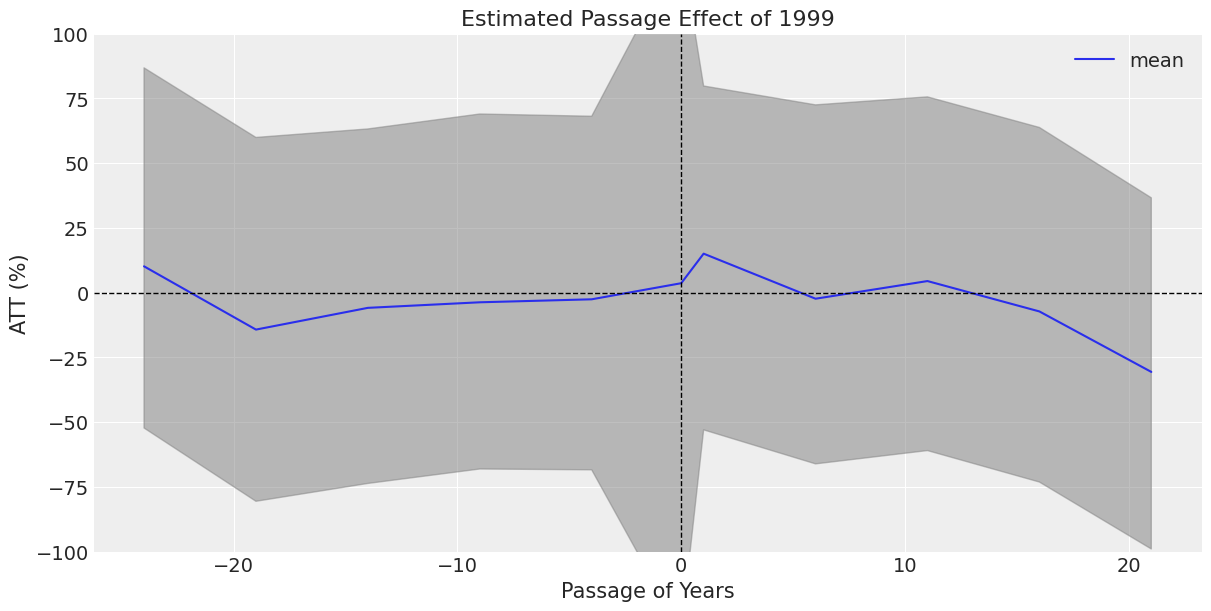

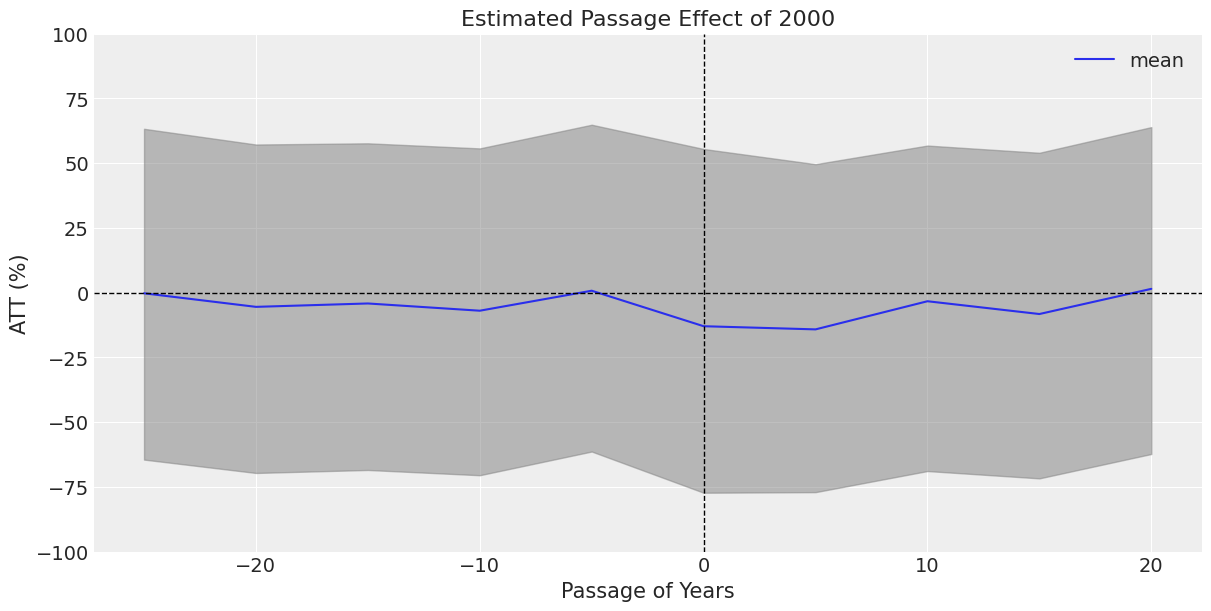

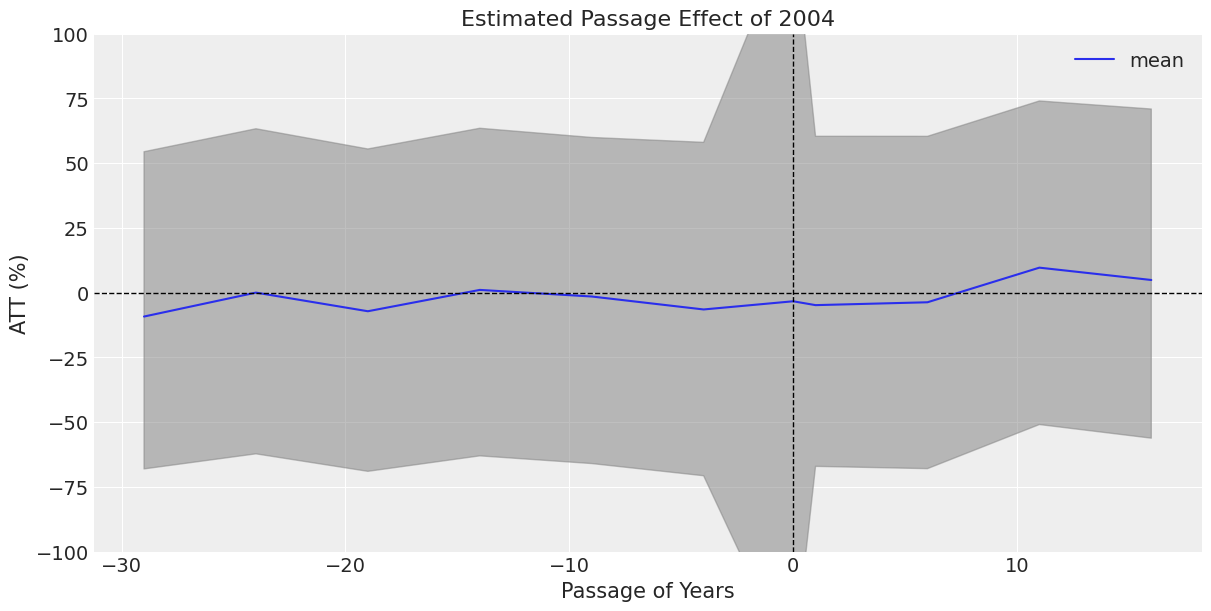

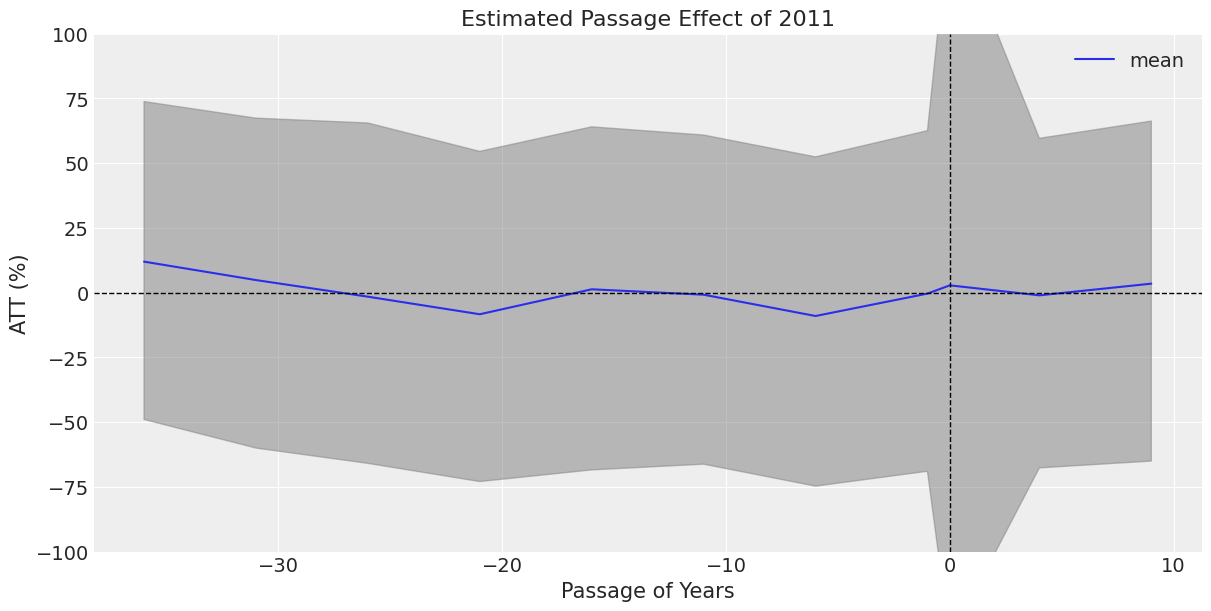

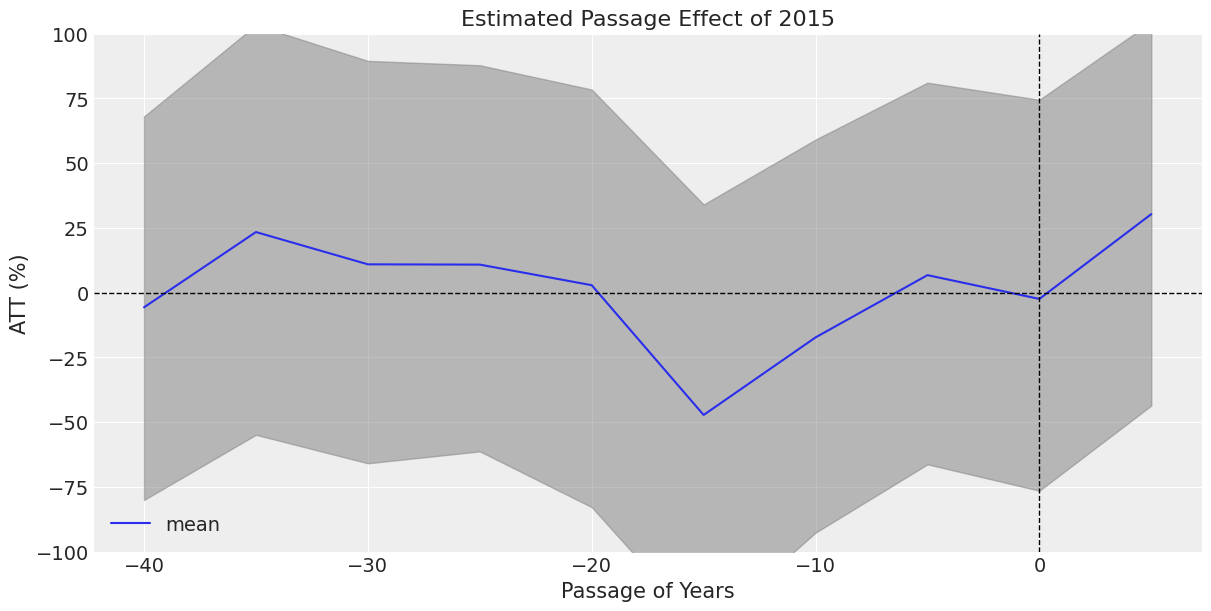

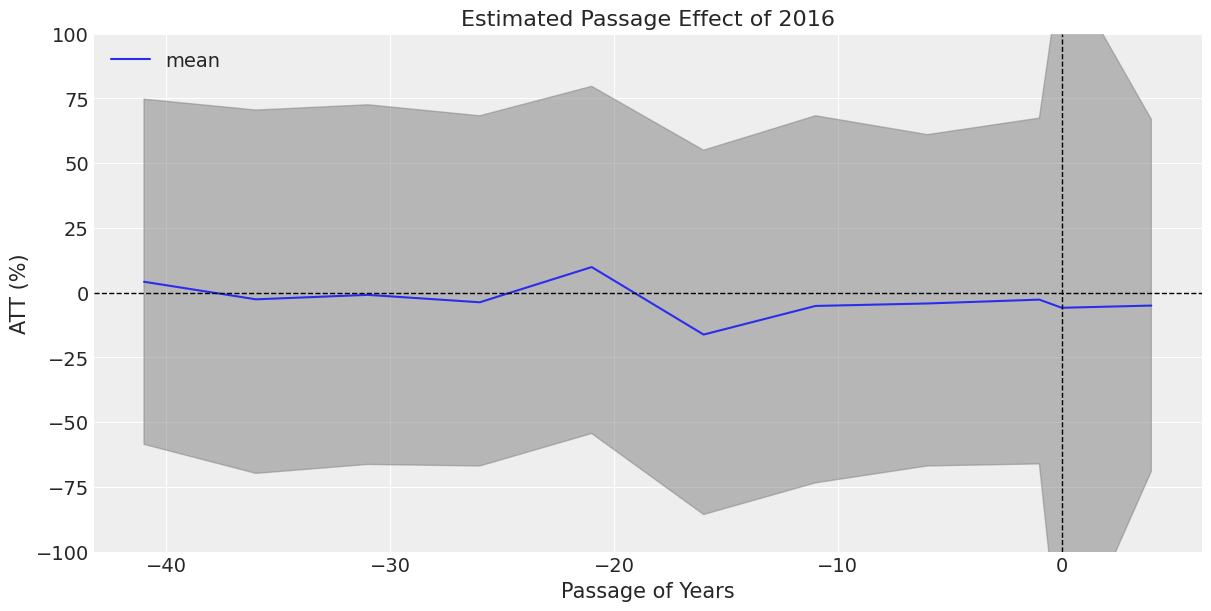

In [28]:
cohort_list = cohort_list[cohort_list != 0]
for cohort in cohort_list:
    get_passage_effects(cohort)

In [6]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')

### モデル2

In [100]:
cohort_list = df['year_bridges_opened'].unique()
cohort_list.sort()
print(cohort_list)
for cohort in cohort_list:
    globals()[f'c{cohort}'] = dmatrix(f'C(years_cohort_{cohort})-1', data=df, return_type='dataframe')

[   0 1973 1976 1979 1983 1987 1988 1989 1991 1992 1995 1996 1999 2000
 2004 2011 2015 2016]


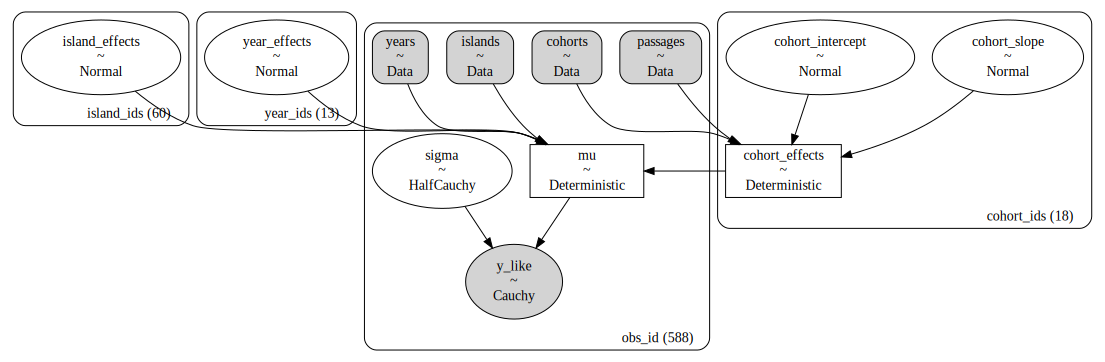

In [133]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])
df['cohorts'], unique_cohorts = pd.factorize(df['year_bridges_opened'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'cohort_ids': unique_cohorts,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as staggered:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passages = pm.Data('passages', df['passage_of_year'], dims='obs_id')
    cohorts = pm.Data('cohorts', df['cohorts'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000, dims='obs_id')

    # cohort * passage
    cohort_intercept = pm.Normal('cohort_intercept', mu=0, sigma=100, dims='cohort_ids')
    cohort_slope = pm.Normal('cohort_slope', mu=0, sigma=100, dims='cohort_ids')
    cohort_effects = pm.Deterministic('cohort_effects', cohort_intercept[cohorts] + cohort_slope[cohorts] * passages, dims='cohort_ids')

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + cohort_effects, dims='obs_id')

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(staggered)

In [114]:
with staggered:
    idata_staggered = pm.sample(draws=1000, tune=1000, nuts_sampler="numpyro", chains=2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [115]:
# 結果の表示
summary = az.summary(idata_staggered, var_names=['cohort_intercept', 'cohort_slope'], hdi_prob=.95)
print(summary)

                          mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
cohort_intercept[2015] -41.523   82.501  -183.092    141.195     23.153   
cohort_intercept[0]    -11.609   28.465   -60.763     39.979      7.296   
cohort_intercept[2004] -37.603  109.063  -240.177    157.445     55.991   
cohort_intercept[1989]  -7.253   70.886  -148.310    128.187      7.123   
cohort_intercept[1983] -22.485   80.031  -173.498    117.564     19.112   
cohort_intercept[1991]  24.710   87.734  -136.587    179.971     37.563   
cohort_intercept[1987]  40.796   89.967  -152.031    185.983     42.115   
cohort_intercept[1992] -17.615   87.973  -194.257    129.259     36.346   
cohort_intercept[1979]  -4.751   60.963  -121.839    114.988      7.525   
cohort_intercept[2000] -25.473   62.243  -135.768    108.009      6.025   
cohort_intercept[1973]  16.994   88.694  -177.016    152.695     14.579   
cohort_intercept[1976]  20.916   89.058  -152.773    216.075     26.559   
cohort_intercept[1988]   

KeyboardInterrupt: 

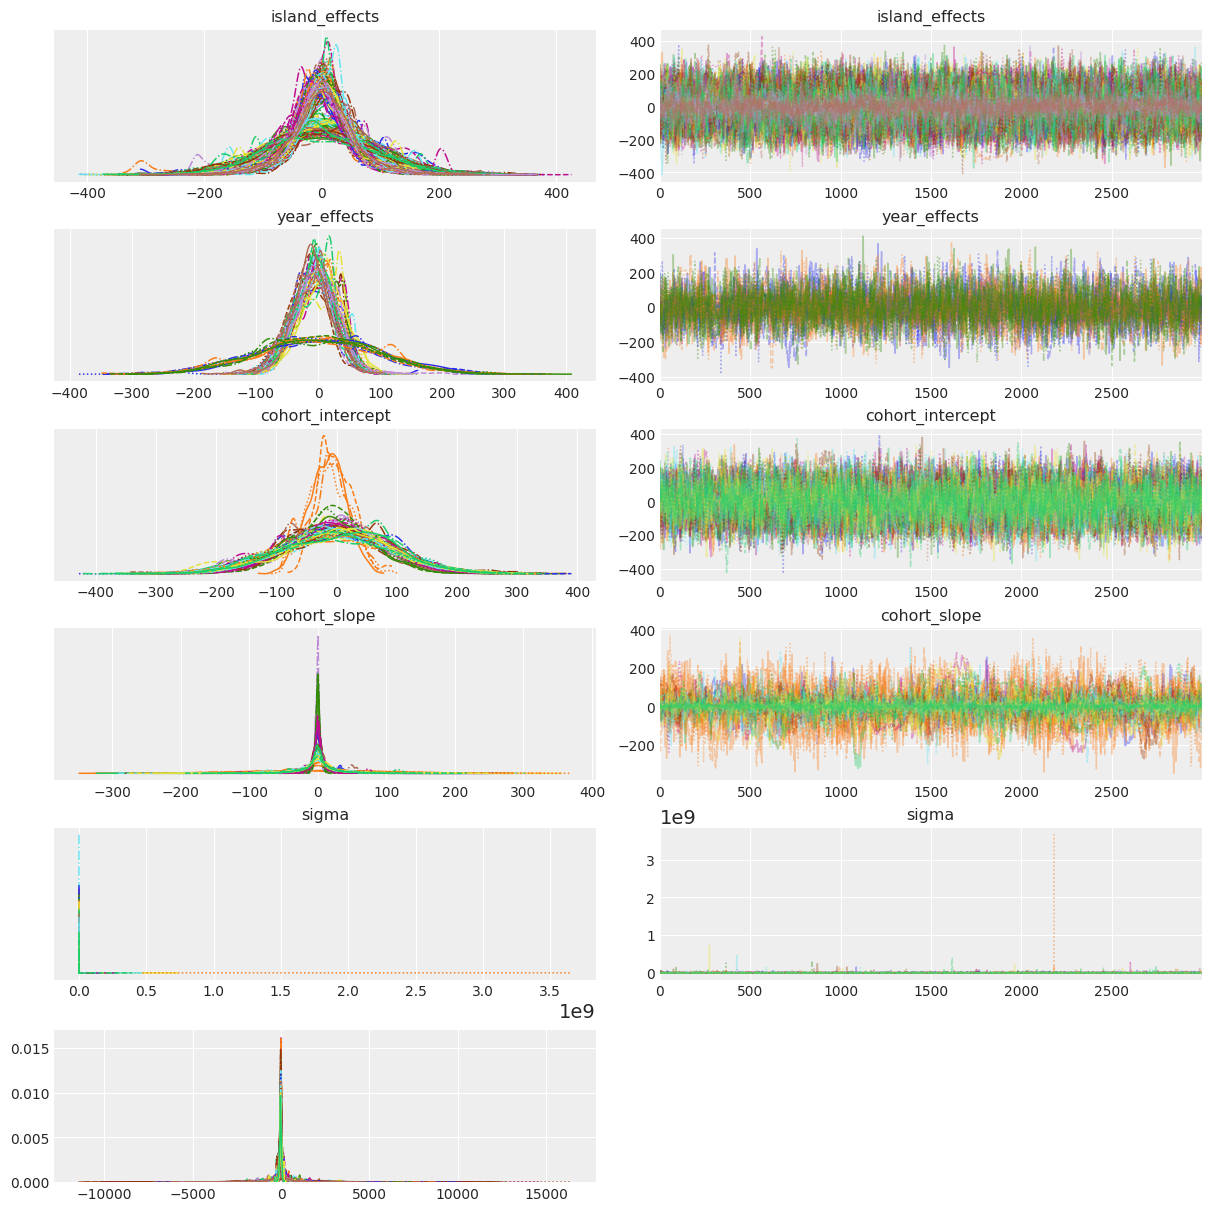

In [110]:
az.plot_trace(idata_staggered);

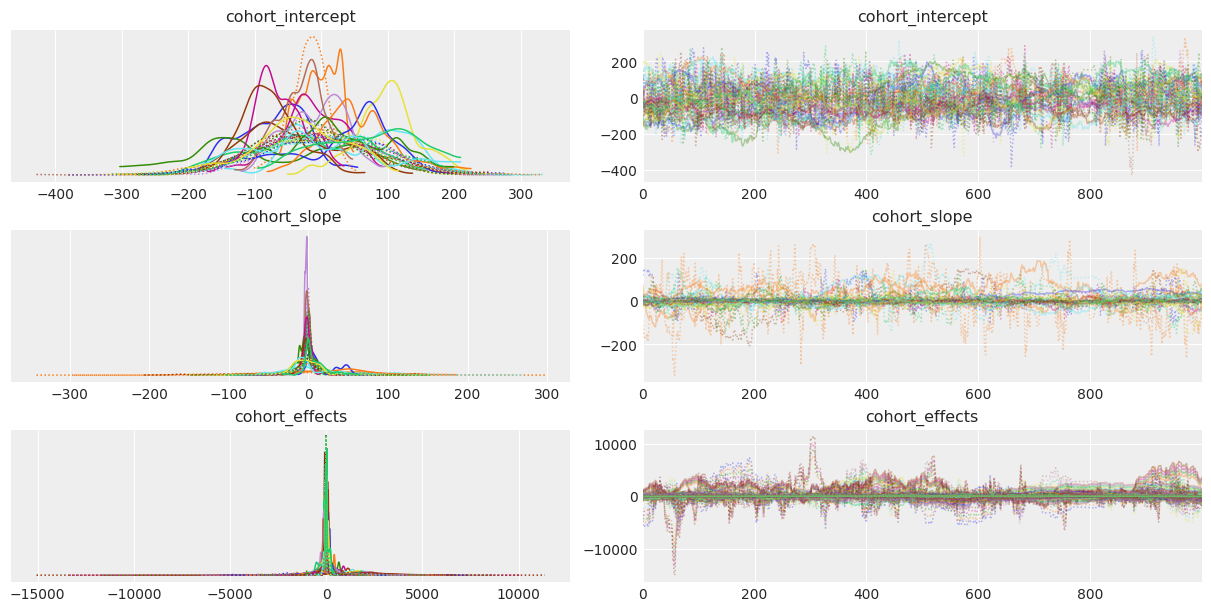

In [131]:
az.plot_trace(idata_staggered, var_names=['cohort_intercept', 'cohort_slope', 'cohort_effects']);

/tmp/ipykernel_150012/3869999289.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_150012/3869999289.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


                        intercept_mean  intercept_hdi_3%  intercept_hdi_97%  \
cohort_intercept[0]            -11.609           -58.318             39.979   
cohort_intercept[1973]          16.994          -163.858            154.441   
cohort_intercept[1976]          20.916          -157.619            199.292   
cohort_intercept[1979]          -4.751          -110.118            114.988   
cohort_intercept[1983]         -22.485          -172.383            108.885   
cohort_intercept[1987]          40.796          -127.435            199.368   
cohort_intercept[1988]           5.934          -123.490            159.495   
cohort_intercept[1989]          -7.253          -147.362            115.864   
cohort_intercept[1991]          24.710          -132.348            175.907   
cohort_intercept[1992]         -17.615          -188.271            124.149   
cohort_intercept[1995]           2.907          -168.229            171.584   
cohort_intercept[1996]         -31.939          -150

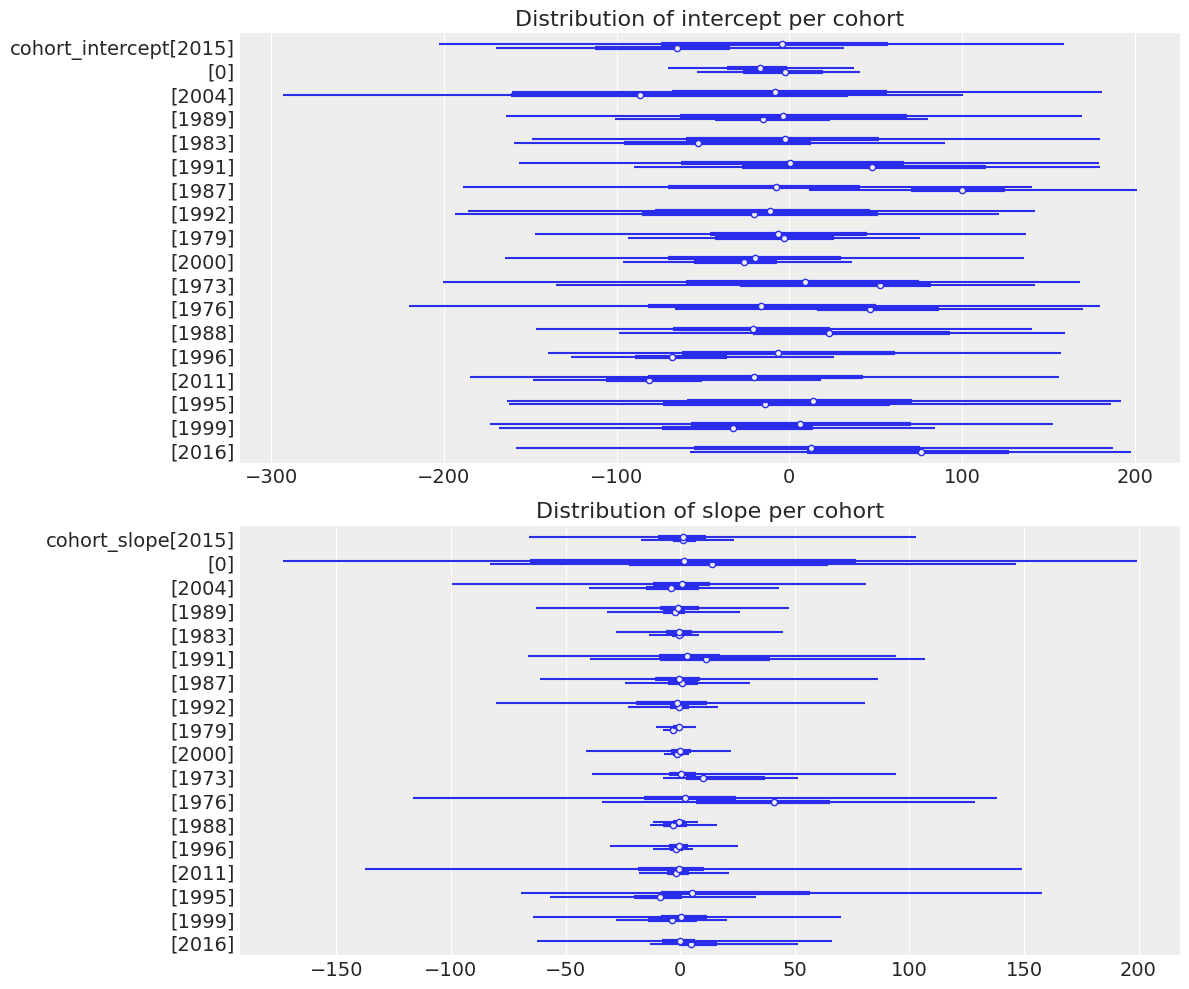

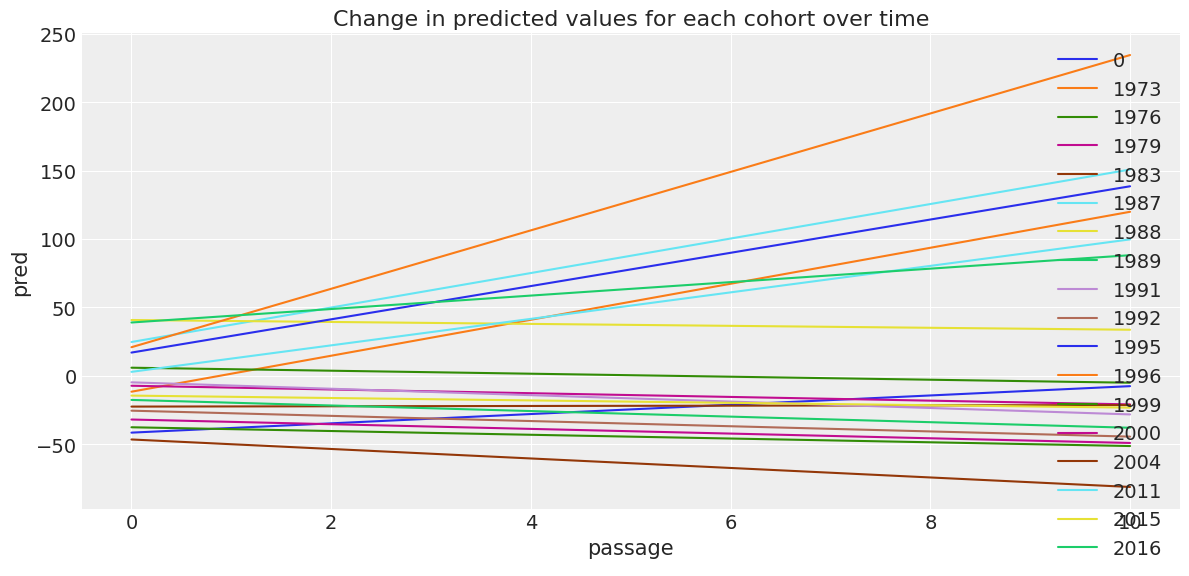

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

def plot_coefficient_changes(idata_staggered, cohort_names=None):
    """
    サンプリング結果から時間を通じた係数の変化を可視化する関数
    
    Parameters:
    -----------
    idata_staggered : PyMC idata_staggered
        サンプリング結果
    cohort_names : list, optional
        コホート名のリスト
    """
    # 1. 係数の時系列プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 切片の分布
    az.plot_forest(
        idata_staggered,
        var_names=['cohort_intercept'],
        ax=ax1,
        hdi_prob=0.95  # 95%確信区間
    )
    ax1.set_title('Distribution of intercept per cohort')
    
    # 傾きの分布
    az.plot_forest(
        idata_staggered,
        var_names=['cohort_slope'],
        ax=ax2,
        hdi_prob=0.95
    )
    ax2.set_title('Distribution of slope per cohort')
    
    plt.tight_layout()
    
    # 2. 時間経過による予測値の変化
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 時間軸の設定
    time_points = np.linspace(0, 10, 100)  # 0から10までの100ポイント
    
    # 各コホートの予測値を計算
    for cohort_idx in range(len(idata_staggered.posterior['cohort_intercept'].mean(dim=['chain', 'draw']))):
        intercept = idata_staggered.posterior['cohort_intercept'].mean(dim=['chain', 'draw'])[cohort_idx].item()
        slope = idata_staggered.posterior['cohort_slope'].mean(dim=['chain', 'draw'])[cohort_idx].item()
        
        # 予測値の計算
        predicted = intercept + slope * time_points
        
        # プロット
        label = f'Cohort {cohort_idx}' if cohort_names is None else cohort_names[cohort_idx]
        ax.plot(time_points, predicted, label=label)
    
    ax.set_xlabel('passage')
    ax.set_ylabel('pred')
    ax.set_title('Change in predicted values for each cohort over time')
    ax.legend()
    
    plt.tight_layout()
    
def analyze_coefficient_trends(idata_staggered):
    """
    係数の傾向を数値的に分析する関数
    
    Parameters:
    -----------
    idata_staggered : PyMC idata_staggered
        サンプリング結果
        
    Returns:
    --------
    DataFrame
        係数の要約統計量
    """
    # 係数の要約統計量を計算
    summary_intercept = az.summary(idata_staggered, var_names=['cohort_intercept'])
    summary_slope = az.summary(idata_staggered, var_names=['cohort_slope'])
    
    # DataFrameに変換
    results = pd.DataFrame({
        'intercept_mean': summary_intercept['mean'],
        'intercept_hdi_3%': summary_intercept['hdi_3%'],
        'intercept_hdi_97%': summary_intercept['hdi_97%'],
        'slope_mean': summary_slope['mean'],
        'slope_hdi_3%': summary_slope['hdi_3%'],
        'slope_hdi_97%': summary_slope['hdi_97%']
    })
    
    return results

# 使用例：
cohort_list.sort()
# 可視化
plot_coefficient_changes(idata_staggered, cohort_names=cohort_list)

# 数値的な分析
results = analyze_coefficient_trends(idata_staggered)
print(results)
